{'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'COL_NAMES': ['label', 'data'], 'DESCR': 'mldata.org dataset: mnist-original', 'target': array([0., 0., 0., ..., 9., 9., 9.])}
(70000, 784)
(70000,)


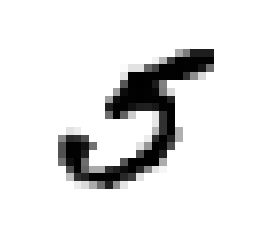

5.0


/home/munachiso/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/munachiso/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.9651


/home/munachiso/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.9646


/home/munachiso/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.9618


/home/munachiso/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/munachiso/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/munachiso/

0.8176666015243307
0.7718133185759085
0.7940785727842095
[-58218.40930831]
[False]
[False]


/home/munachiso/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/munachiso/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/munachiso/

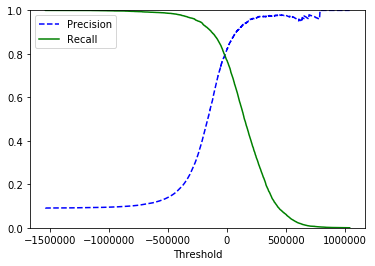

0.8909227683049148
0.6554141302342741


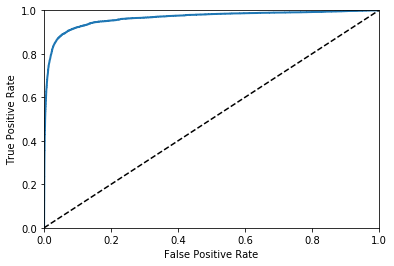

0.96471861067818


/home/munachiso/.local/lib/python3.5/site-packages/matplotlib/legend.py:640: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	right
	lower left
	lower right
	center left
	lower center
	center
	upper center
	upper left
	center right

  % (loc, '\n\t'.join(self.codes)))


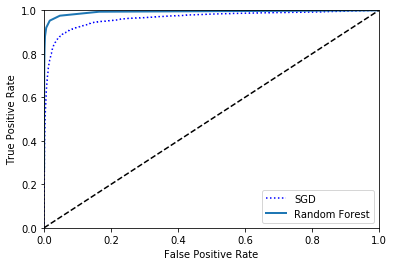

/home/munachiso/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/munachiso/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/munachiso/

/home/munachiso/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/munachiso/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/munachiso/

/home/munachiso/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/munachiso/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/munachiso/

[5.]
45
[5.]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


/home/munachiso/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/munachiso/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/munachiso/

[0.84833033 0.87044352 0.86282942]


/home/munachiso/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/munachiso/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/munachiso/

array([0.91141772, 0.90664533, 0.9119868 ])

In [12]:
from sklearn.base import clone
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_mldata
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler


import matplotlib
import matplotlib.pyplot as plt
import numpy as np

##Classes
class Never5Classifier(BaseEstimator):
 def fit(self, X, y=None):
  pass
 def predict(self, X):
  return np.zeros((len(X), 1), dtype=bool)
##








##Functions
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
 plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
 plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
 plt.xlabel("Threshold")
 plt.legend(loc="upper left")
 plt.ylim([0, 1])

def plot_roc_curve(fpr, tpr, label=None):
 plt.plot(fpr, tpr, linewidth=2, label=label)
 plt.plot([0, 1], [0, 1], 'k--')
 plt.axis([0, 1, 0, 1])
 plt.xlabel('False Positive Rate')
 plt.ylabel('True Positive Rate')
##









##Securing the training data
#Fetching the MNIST data
mnist = fetch_mldata('MNIST original')
print(mnist)
#loading the data and target arrays (the DSERC is metadata)
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)
#viewing an image from the dataset
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
 interpolation="nearest")
plt.axis("off")
plt.show()
print(y[36000])
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
#shuffling the training data to ensure uniformity despite cross validation
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]
##








##Training the binary Classifier
#creating target vectors
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)
#training stochastic gradient descent classifier and predicting a digit
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])
##








##Measuring accuracy using cross validation
#Implementing cross validation
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
 clone_clf = clone(sgd_clf)
 X_train_folds = X_train[train_index]
 y_train_folds = (y_train_5[train_index])
 X_test_fold = X_train[test_index]
 y_test_fold = (y_train_5[test_index])
 clone_clf.fit(X_train_folds, y_train_folds)
 y_pred = clone_clf.predict(X_test_fold)
 n_correct = sum(y_pred == y_test_fold)
 print(n_correct / len(y_pred)) # prints 0.9502, 0.96565 and 0.96495
#using cross_val_score() function to evaluate classifier 
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
#making a point about classifiers by measuring cross validation of a classifier that says none of the images are "5"s
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
##









##Confusion matrix
#getting predictions for the confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train, 
                    y_train_5, cv=3)
#creating the confusion matrix
confusion_matrix(y_train_5, y_train_pred)
##









##Precision, recall, f1 score
print(precision_score(y_train_5, y_train_pred) )
print(recall_score(y_train_5, y_train_pred) )
print (f1_score(y_train_5, y_train_pred) )
##







##Understanding Precision Recall tradeoff using threshold
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)
#raising the threshold of the SGDClassifier which has a default of 0
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
print (y_some_digit_pred)
#getting the scores of all instances in the training set using the cross_val_predict()
#specifying that you want it to return decision scores instead of predictions:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
 method="decision_function")
#compute precision and recall for all possible thresholds using the precision_recall_curve() function:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
#aiming for 90% precision using threshold of about 70,000. In shorthand,
y_train_pred_90 = (y_scores > 70000)
print ( precision_score(y_train_5, y_train_pred_90) )
print ( recall_score(y_train_5, y_train_pred_90) )
##








##ROC Curve for SDG
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
plot_roc_curve(fpr, tpr)
plt.show()
#area under the curve
print( roc_auc_score(y_train_5, y_scores) )
##








##ROC Curve for random forest classifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
 method="predict_proba")
#using the positive class’s probability as the score:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)
#plotting ROC curve
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()
#AUC score
roc_auc_score(y_train_5, y_scores_forest)
##








##Multi-class classification
#using SGD for multi‐class classification scikit-learn automatically suses OvA
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])
#showing the decision scores
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores
np.argmax(some_digit_scores)
sgd_clf.classes_
sgd_clf.classes_[5]
#If you want to force ScikitLearn to one-v-one or one-v-all
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print( ovo_clf.predict([some_digit]) )
print( len(ovo_clf.estimators_) )
#training a RandomForestClassifier is just as easy:
forest_clf.fit(X_train, y_train)
print( forest_clf.predict([some_digit]) )
#listing of probabilities that the classifier assigned to each instance for each class
print (forest_clf.predict_proba([some_digit]) )
#evaluating SGDClassifier using the cross_val_score
print (cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy") )
#scaling the inputs increases accuracy to 90%
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
##








##Error Analysis Of course, if this were a real project, you would follow the steps in your Machine
Learning project checklist (see Appendix B): exploring data preparation options, try‐
ing out multiple models, shortlisting the best ones and fine-tuning their hyperpara‐
meters using GridSearchCV, and automating as much as possible, as you did in the
previous chapter. Here, we will assume that you have found a promising model and
you want to find ways to improve it. One way to do this is to analyze the types of
errors it makes.
First, you can look at the confusion matrix. You need to make predictions using the
cross_val_predict() function, then call the confusion_matrix() function, just like
you did earlier:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
>>> conf_mx = confusion_matrix(y_train, y_train_pred)
>>> conf_mx
##
